<a href="https://colab.research.google.com/github/DJCordhose/deep-learning-crash-course-notebooks/blob/master/tf-v2/ux-rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training on Mouse-Movements

Our challenge is to predict which button a user is going to click based on previous mouse movements. One application might be to highlight the button before hover and give a clearer guidance to the user: 

![Buttons highlighting when the machine thinks I am going to click them soon](https://raw.githubusercontent.com/DJCordhose/ux-by-tfjs/master/img/simpleRNN.gif "Highlighting in Advance")

Even though the model will vary between different machines and different users, we have a default data set you can use to train the model.

Read the complete article here https://dev.to/djcordhose/improving-user-experience-with-tensorflow-js-4693 and have a look at the browser application http://djcordhose.github.io/ux-by-tfjs/dist that can load our model to make online predictions.

In [1]:
# for colab
!pip install -q tf-nightly-gpu-2.0-preview

    100% |████████████████████████████████| 345.3MB 57kB/s 
    100% |████████████████████████████████| 3.0MB 8.6MB/s 
    100% |████████████████████████████████| 358kB 10.4MB/s 
    100% |████████████████████████████████| 61kB 20.5MB/s 
thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.
spacy 2.0.18 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
fastai 1.0.51 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.


In [3]:
import tensorflow as tf
print(tf.__version__)

2.0.0-dev20190412


In [4]:
# a small sanity check, does tf seem to work ok?
hello = tf.constant('Hello TF!')
print("This works: {}".format(hello))

This works: b'Hello TF!'


In [5]:
# this should return True even on Colab
tf.test.is_gpu_available()

True

In [6]:
tf.test.is_built_with_cuda()

True

In [7]:
tf.executing_eagerly()

True

## load data

In [8]:
import pandas as pd
print(pd.__version__)

0.22.0


In [0]:
# local
# URL = '../data/sample4.json'

# remote
URL = 'https://raw.githubusercontent.com/DJCordhose/ux-by-tfjs/master//data/sample4.json'


df = pd.read_json(URL, typ='series')

In [10]:
len(df)

236

In [11]:
df.head()

0    {'x': [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0...
1    {'x': [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0...
2    {'x': [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0...
3    {'x': [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0...
4    {'x': [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0...
dtype: object

In [0]:
X = [item['x'] for item in df]

In [13]:
X[0]

[[0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0,

In [0]:
y = [item['y'] - 1 for item in df]

In [15]:
y[0]

0

## pre-process data into chunks

In [0]:
from math import floor

def make_chunks(list_to_chunk, chunk_size):
    length = len(list_to_chunk)
    assert length / chunk_size == floor(length / chunk_size), "length of data must be multiple of segment length"
    for chunk_start in range(0, length, chunk_size):
        yield list_to_chunk[chunk_start : chunk_start + chunk_size]

In [0]:
import numpy as np

CHUNK_SIZE = 25
# only use the final segments 
SEGMENTS = 2

X_expanded = []
y_expanded = []

for x_el, y_el in zip(X, y):
    chunks = list(make_chunks(x_el, CHUNK_SIZE))
    chunks = chunks[len(chunks) - SEGMENTS:]
    labels = [y_el] * SEGMENTS
    for seq, label in zip(chunks, labels):
        X_expanded.append(seq)
        y_expanded.append(label)

X_expanded = np.array(X_expanded)
y_expanded = np.array(y_expanded)

In [18]:
X_expanded.shape

(472, 25, 5)

In [19]:
X_expanded[100]

array([[686, 438,   2,  -2,   7],
       [686, 437,   0,  -2,  15],
       [683, 439,  -6,   4,  28],
       [676, 447, -14,  16,   7],
       [668, 457, -16,  20,   9],
       [658, 468, -20,  22,   7],
       [653, 475, -10,  14,   0],
       [648, 480, -10,  10,   9],
       [645, 484,  -6,   8,   1],
       [644, 486,  -2,   4,   8],
       [643, 486,  -2,   0,   7],
       [643, 487,   0,   2,  14],
       [646, 485,   6,  -4,  22],
       [658, 478,  24, -14,   6],
       [676, 463,  36, -30,   8],
       [693, 448,  34, -30,   9],
       [717, 427,  48, -42,   5],
       [733, 415,  32, -24,   8],
       [743, 406,  20, -18,   6],
       [747, 402,   8,  -8,   6],
       [748, 401,   2,  -2,   8],
       [749, 401,   2,   0,   7],
       [750, 401,   2,   0,   9],
       [750, 404,   0,   6,  20],
       [747, 411,  -6,  14,   6]])

In [20]:
X_expanded[100][0]

array([686, 438,   2,  -2,   7])

In [21]:
y_expanded[100]

1

In [22]:
np.unique(y_expanded)

array([0, 1, 2])

In [0]:
assert np.array_equal(np.unique(y_expanded), [0, 1, 2])

## Recurrent Neural Networks

RNNs work on sequences of input data and can learn which part of the history is relevant. Thus, they can learn which mouse events are relevant.

### Simple RNN

Inexpensive in terms of model size and compute, but are bad at remembering events far in the past.

### LSTM

Can learn which events in the past are important and can thus much better match a certain mouse path. However, 4x more expensive than the simple RNN.

### GRU

Like LSTMs, but only 3x more expensive. Often as good as LSTMs.


## Training

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, BatchNormalization
from tensorflow.keras.models import Sequential, Model

In [0]:
# experiment with
# - type of RNN: SimpleRNN, LSTM, GRU
# - number of units
# - dropout
# - BatchNormalization: yes/no

n_steps = len(X_expanded[0])
n_features = len(X_expanded[0][0])
n_buttons = 3

model = Sequential()
model.add(SimpleRNN(units=50, activation='tanh', input_shape=(n_steps, n_features), name="RNN_Input", 
# model.add(GRU(units=50, activation='tanh', input_shape=(n_steps, n_features), name="RNN_Input", 
# recurrent_dropout makes things slow              
#               dropout=0.1, recurrent_dropout=0.1))
                dropout=0.1))
# model.add(GRU(units=50, activation='tanh', input_shape=(n_steps, n_features), name="RNN_Input"))
model.add(BatchNormalization())
model.add(Dense(units=n_buttons, name='softmax', activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [26]:
%%time

EPOCHS = 200
BATCH_SIZE = 200

history = model.fit(X_expanded, y_expanded, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, verbose=0, validation_split=0.2)

CPU times: user 25.5 s, sys: 2.91 s, total: 28.4 s
Wall time: 18.3 s


In [27]:
loss, accuracy = model.evaluate([X_expanded], y_expanded, batch_size=BATCH_SIZE)
accuracy

472/472 [==============================] - 0s 642us/sample - loss: 0.6878 - accuracy: 0.7542


0.7542373

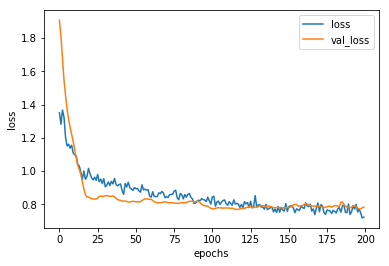

In [28]:
%matplotlib inline

import matplotlib.pyplot as plt

# plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(['loss', 'val_loss'])

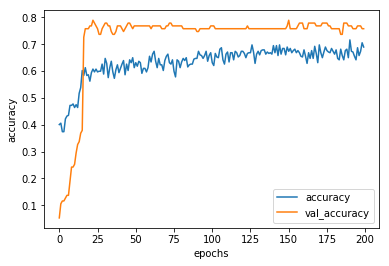

In [29]:
plt.ylabel('accuracy')
plt.xlabel('epochs')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.legend(['accuracy', 'val_accuracy'])

In [30]:
model.predict([[X_expanded[0]]])

array([[0.68819827, 0.14252734, 0.16927442]], dtype=float32)

In [31]:
model.predict([[X_expanded[0]]]).argmax()

0

In [32]:
y_expanded[0]

0

In [0]:
y_pred = model.predict([X_expanded]).argmax(axis=1)

In [34]:
cm = tf.math.confusion_matrix(labels=y_expanded, predictions=y_pred)
cm

<tf.Tensor: id=7560, shape=(3, 3), dtype=int32, numpy=
array([[126,  24,  20],
       [ 17,  95,  26],
       [  7,  22, 135]], dtype=int32)>

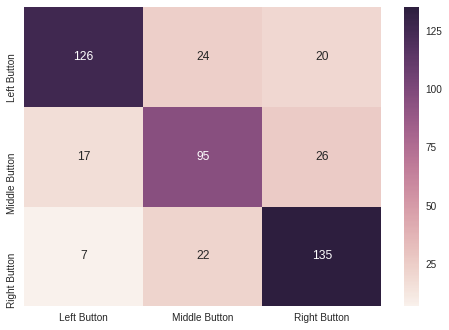

In [35]:
import seaborn as sns

classes = ["Left Button", "Middle Button", "Right Button"]

sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)

## Convert Model into tfjs format

In [0]:
model.save('ux.hd5')

In [37]:
!ls -l

total 76
drwxr-xr-x 1 root root  4096 Apr  4 20:20 sample_data
-rw-r--r-- 1 root root 72384 Apr 12 14:15 ux.hd5


In [38]:
!pip install -q tensorflowjs

    100% |████████████████████████████████| 81kB 7.2MB/s 
    100% |████████████████████████████████| 13.9MB 3.1MB/s 
    100% |████████████████████████████████| 86.5MB 388kB/s 
thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.


In [0]:
!tensorflowjs_converter --input_format keras ux.hd5 tfjs

In [40]:
!ls -l tfjs

total 20
-rw-r--r-- 1 root root 12612 Apr 12 14:15 group1-shard1of1.bin
-rw-r--r-- 1 root root  3172 Apr 12 14:15 model.json


Download using _Files_ menu on the left